In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [2]:
Nx = Ny = 20
phys_dims = [1,1]
g = pp.CartGrid([Nx, Ny], phys_dims)
g.compute_geometry()

C:\Users\ingri\AppData\Local\Programs\Python\Python39\lib\site-packages\porepy\viz\plot_grid.py:241: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z)


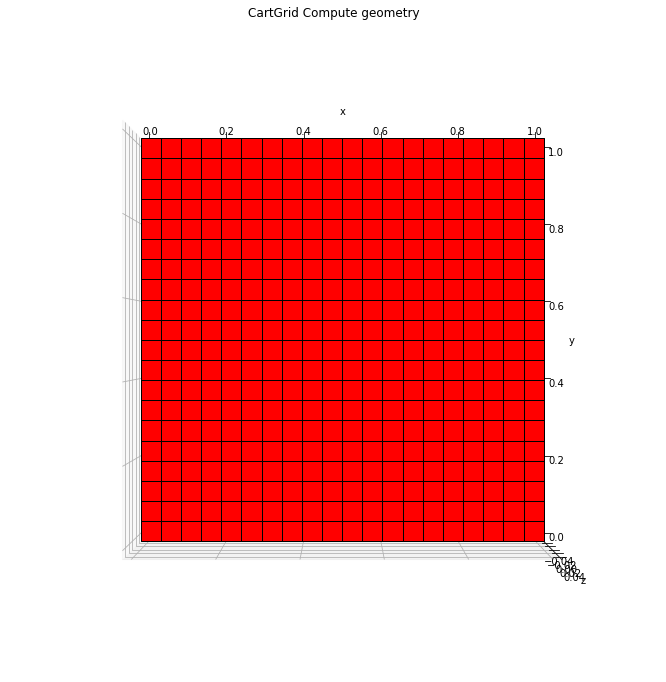

In [3]:
pp.plot_grid(g, figsize=(15, 12))

In [4]:
# Permeability
perm = pp.SecondOrderTensor(np.ones(g.num_cells))                     

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}

In [5]:
data_key = "flow"
data = pp.initialize_default_data(g, {}, data_key, parameters)

In [6]:
flow_discretization = pp.Tpfa(data_key)
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

rhs_discretization = pp.ScalarSource(data_key)
rhs_discretization.discretize(g, data)
_, b_rhs = rhs_discretization.assemble_matrix_rhs(g, data)

p_tpfa = sps.linalg.spsolve(A, b_flow+b_rhs)

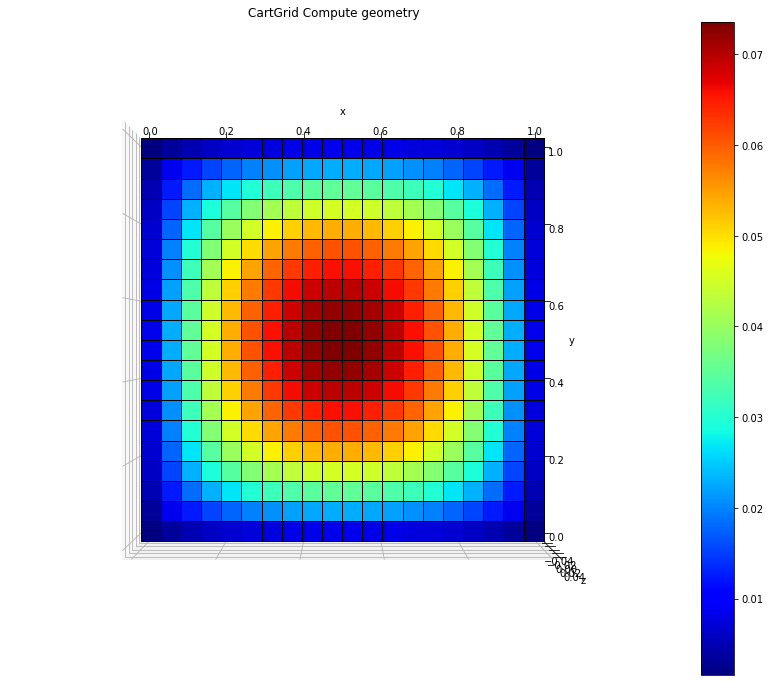

In [7]:
pp.plot_grid(g, p_tpfa, figsize=(15, 12))

In [8]:
flow_discretization = pp.Mpfa(data_key)
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

p_mpfa = sps.linalg.spsolve(A, b_flow+b_rhs)

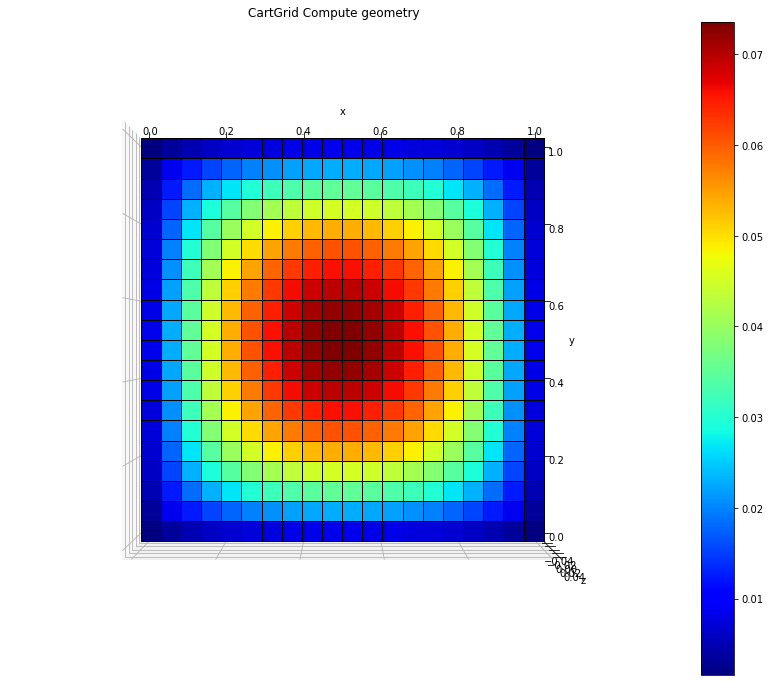

In [9]:
pp.plot_grid(g, p_mpfa, figsize=(15, 12))

In [10]:
flow_discretization = pp.MVEM("flow")
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

rhs_discretization = pp.DualScalarSource("flow")

data[pp.PARAMETERS]["flow"]["source"] = data[pp.PARAMETERS]["flow"]["source"]
rhs_discretization.discretize(g, data)
_, b_rhs = rhs_discretization.assemble_matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

# Extract the normal flux and pressure from the solution
u_mvem = flow_discretization.extract_flux(g, up, data)
p_mvem = flow_discretization.extract_pressure(g, up, data) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = flow_discretization.project_flux(g, u_mvem, data)

C:\Users\ingri\AppData\Local\Programs\Python\Python39\lib\site-packages\porepy\viz\plot_grid.py:127: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


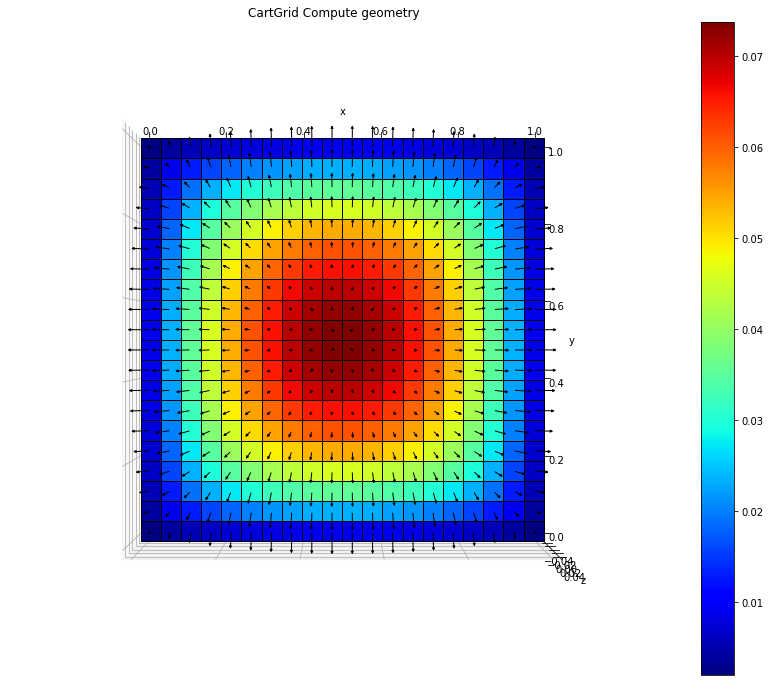

In [11]:
pp.plot_grid(g, p_mvem, P0u * 0.2, figsize=(15, 12))

In [12]:
gb, _ = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)

In [13]:
# Thickness of fracture
aperture = 1e-3
fracture_perm = 1e-5

for g, d in gb:
    # The concept of specific volumes accounts for the thickness
    # of the fracture, which is collapsed in the mixed-dimensional
    # model.
    specific_volumes = np.power(aperture, gb.dim_max()-g.dim)
    # Permeability
    k = np.ones(g.num_cells) * specific_volumes
    if g.dim < gb.dim_max():
        k *= fracture_perm
    perm = pp.SecondOrderTensor(k)                     

    # Unitary scalar source already integrated in each cell
    f = 1e-2* g.cell_volumes * specific_volumes 

    # Boundary conditions
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
    bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
    bc_val = np.zeros(g.num_faces)
    bc_val[b_faces] = g.face_centers[1, b_faces]

    parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    pp.initialize_data(g, d, data_key, parameters)

for e, d in gb.edges():
        gl, _ = gb.nodes_of_edge(e)
        mg = d["mortar_grid"]
        # Division through aperture/2 may be thought of as taking the gradient, i.e.
        # dividing by the distance from the matrix to the center of the fracture.
        kn = fracture_perm / (aperture/2)
        pp.initialize_data(mg, d, data_key, {"normal_diffusivity": kn})

In [14]:
flow_discretization = pp.Tpfa(data_key)
source_discretization = pp.ScalarSource(data_key)
for g, d in gb:
        d[pp.PRIMARY_VARIABLES] = {"pressure": {"cells": 1}}
        d[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization,
                                             "source": source_discretization}}
        
flow_coupling_discretization = pp.RobinCoupling(data_key, flow_discretization)        
for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {"mortar_flux": {"cells": 1}}
    d[pp.COUPLING_DISCRETIZATION] = {
        "lambda": {
            g1: ("pressure", "diffusive"),
            g2: ("pressure", "diffusive"),
            e: ("mortar_flux", flow_coupling_discretization),
        }
    }


In [15]:
assembler = pp.Assembler(gb)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
solution = sps.linalg.spsolve(A, b)
assembler.distribute_variable(solution)

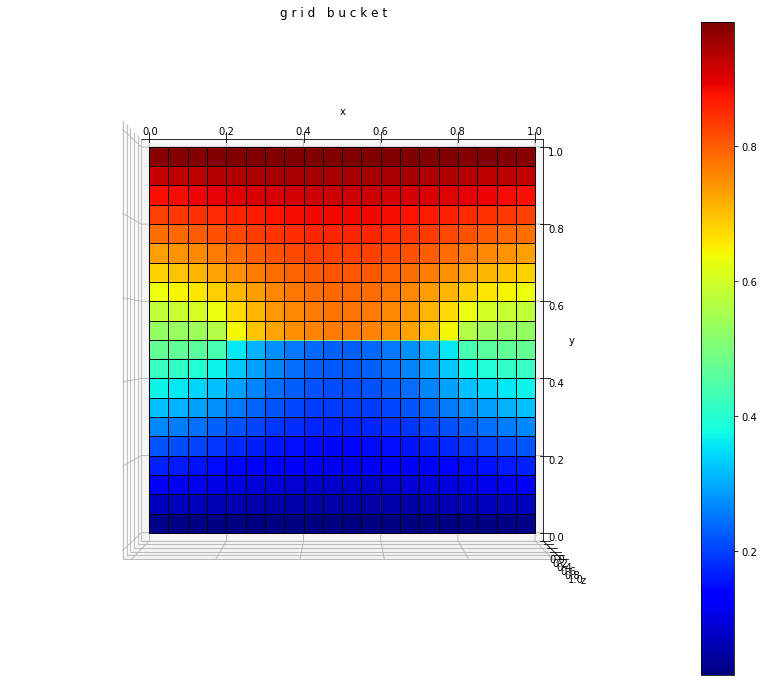

In [16]:
pp.plot_grid(gb, "pressure",figsize=(15, 12))

In [17]:
g_2d = gb.grids_of_dimension(2)[0]
d_2d = gb.node_props(g_2d)
p_2d = d_2d[pp.STATE]["pressure"]

In [18]:
print(pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False))

(Grid bucket containing 2 grids and 1 interfaces
Maximum dimension present: 2 
Minimum dimension present: 1 
1 grids of dimension 2 with in total 400 cells
1 grids of dimension 1 with in total 12 cells
1 interfaces between grids of dimension 2 and 1 with in total 24 mortar cells
, {'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1})
